<a href="https://colab.research.google.com/github/pistacliffcho/Experimental-Code/blob/master/Batches_as_Rows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError

In [ ]:
#@title Simulating ragged arrays

def true_function(x):
  """Function we want to fit"""
  ans = np.exp(x) + 3 * x +  2 * x**2
  return ans

def simulate_one_batch(fxn=true_function, mean_n=10):
  """Simulate a single batch where sum f(x) only is known"""
  n = np.random.poisson(size=1, lam = mean_n-1) + 1
  xs = np.random.normal(size=n)
  y = fxn(xs) + np.random.normal(size=n)
  return xs, np.sum(y)

def simulate_batches(fxn=true_function, n_batches=3):
  """Simulates sets of batches with random batch sizes."""
  Xs=[]
  Ys=[]
  for _ in range(n_batches):
    this_X, this_Y = simulate_one_batch(fxn=fxn)
    Xs.append(this_X)
    Ys.append(this_Y)
  return {'X':Xs, 'Y':Ys}

simulate_batches()

{'X': [array([ 0.26212857,  0.38005195,  0.10269202, -0.53748817, -0.60165735,
          0.56318383, -1.02050222, -1.55862381,  1.70384821, -0.87246213,
          1.44090196, -0.50745536]),
  array([-0.5836057 ,  0.58142638, -0.17321451, -0.45301449,  1.06215735,
         -1.18189296, -1.11029173, -1.23316392, -1.30767073]),
  array([-0.6634542 , -0.96462615,  1.72417977,  1.53050078,  0.15931002,
         -0.09462272, -0.01976628, -0.52267019, -2.21472057, -0.53037211])],
 'Y': [38.48165834070023, 7.94530854194803, 34.82081477491847]}

In [ ]:
#@title Plotting function
def compare_model(model, true_f):
  """Visualize fit compared to truth"""
  grid = np.linspace(start=-2, stop=2, num=100)
  true_y = true_f(grid)
  pred_y = []
  for this_x in grid:
    this_y = model.learned_f(
        np.array([this_x]).reshape([1,1])
      )
    pred_y.append(this_y[0,0])

  ax=sns.lineplot(
    x=grid,
    y=true_y,
    label = 'True Function'
  )
  ax=sns.lineplot(
    x=grid,
    y=np.array(pred_y),
    label = 'Fitted Function'
  )
  return ax

In [ ]:
#@title Cubic fit model
class PolynomialRaggedBatchModel(Model):
  """Uses cubic polynomial for the learned function"""
  def __init__(self):
    super().__init__()
    self.coefs = tf.Variable([1., 2., 3., 4.])

  def learned_f(self, x):
    b = self.coefs
    ans = b[0] + b[1] * x + b[2] * x ** 2 + b[3] * x ** 3
    return ans

  def summed_f(self, one_x_batch):
    yhats = tf.map_fn(self.learned_f, one_x_batch)
    ans = tf.math.reduce_sum(yhats)
    return ans

  def call(self, inputs):
    ans = tf.map_fn(self.summed_f,
                    inputs,
                    fn_output_signature=tf.float32)
    return ans

poly_mod = PolynomialRaggedBatchModel()

In [ ]:
#@title Simulate and fit
batches = simulate_batches(n_batches=1000)
X = tf.ragged.constant(batches['X'])
Y = tf.ragged.constant(batches['Y'])

poly_mod.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                 loss=MeanSquaredError(),
                 metrics=[keras.metrics.MeanSquaredError()],
                 run_eagerly=False)

poly_mod.fit(X, Y,
             epochs=25,
             batch_size=10)

Epoch 1/25
100/100 [==============================] - 3s 15ms/step - loss: 1326.2618 - mean_squared_error: 1326.2618
Epoch 2/25
100/100 [==============================] - 1s 15ms/step - loss: 788.5304 - mean_squared_error: 788.5306
Epoch 3/25
100/100 [==============================] - 2s 17ms/step - loss: 480.8527 - mean_squared_error: 480.8527
Epoch 4/25
100/100 [==============================] - 4s 39ms/step - loss: 296.6183 - mean_squared_error: 296.6182
Epoch 5/25
100/100 [==============================] - 1s 15ms/step - loss: 196.7039 - mean_squared_error: 196.7039
Epoch 6/25
100/100 [==============================] - 2s 17ms/step - loss: 144.9738 - mean_squared_error: 144.9738
Epoch 7/25
100/100 [==============================] - 2s 17ms/step - loss: 115.7603 - mean_squared_error: 115.7603
Epoch 8/25
100/100 [==============================] - 2s 19ms/step - loss: 95.3556 - mean_squared_error: 95.3556
Epoch 9/25
100/100 [==============================] - 2s 22ms/step - loss: 81.41

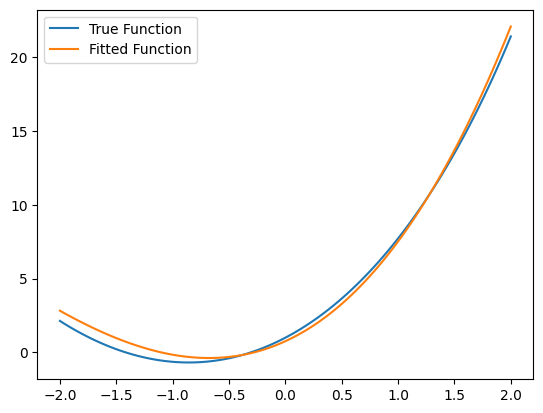

In [ ]:
#@title Comparing fit to real function
ax=compare_model(poly_mod,
              true_function)